In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Считывание данных

In [2]:
data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Удаляем колонку Id

In [4]:
data = data.drop(columns = ['Id'])

Извлекаем целевой массив и удаляем его из данных

In [5]:
y = np.log1p(data['SalePrice'])
data = data.drop(columns = ['SalePrice'])



In [6]:
baseline = y.mean()
print(baseline)

12.024057394918371


In [7]:
y.max()

13.534474352733596

Разбиваем выборку на тренировочную и тестовую 

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = 10)

Просматриваем числовые характеристики объектов. Находим среднее значение для каждой числовой характеристики. Заполняем пустые ячейки средними значениями. Затем строим диаграмму, отражающую зависимость целевой переменной от различных числовых параметров

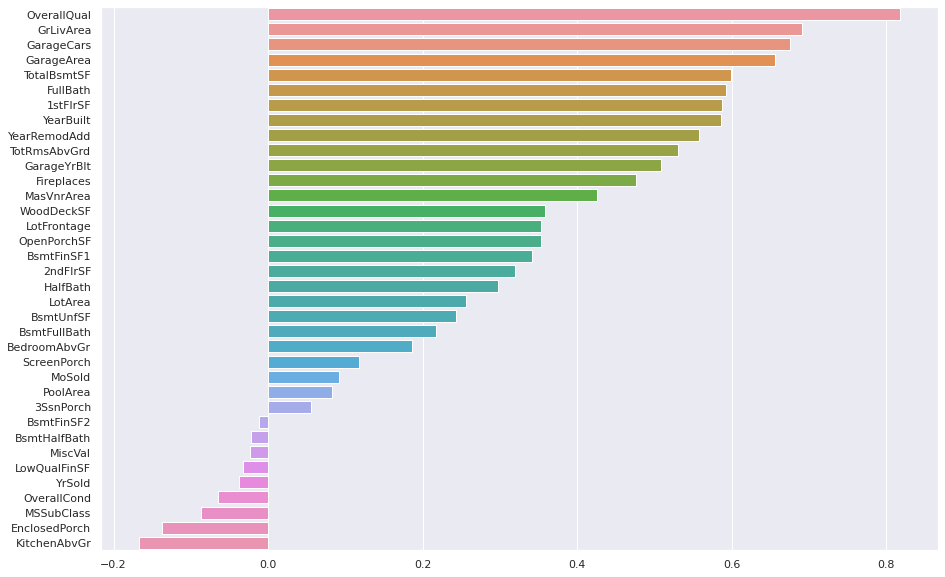

In [9]:
numeric_data = x_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

x_train = x_train.fillna(numeric_data_mean)
x_test = x_test.fillna(numeric_data_mean)

correlations = x_train[numeric_features].corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y = correlations.index, x = correlations)
plot.figure.set_size_inches(15, 10)

Далее выберем все категориальные признаки и по аналогии заполним пустые ячейки

In [10]:
categor = list(x_train.dtypes[x_train.dtypes == 'object'].index)
x_train[categor] = x_train[categor].fillna('Empty')
x_test[categor] = x_test[categor].fillna('Empty')

Создадим первую версию модели с L1 регуляризатором - Lasso

In [11]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), categor),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)
print("RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))


RMSE = 0.4092
RMSE = 0.3951


На данном этапе была построена, которая подогнала весы. Но остались нетронутыми гиперпараметр, а именно коэффициент регуляризации

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

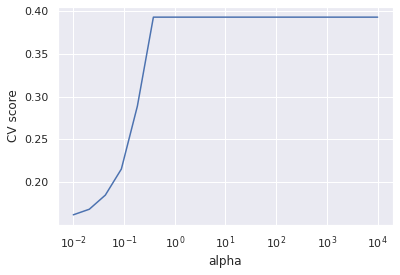

In [12]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(x_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Теперь повторим процесс обучения, только уже с найденным гиперпараметром

In [13]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.1467


Проанализируем данные, которые мы получили. Посмотрим на гистограмму распределения квадратичной ошибки

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

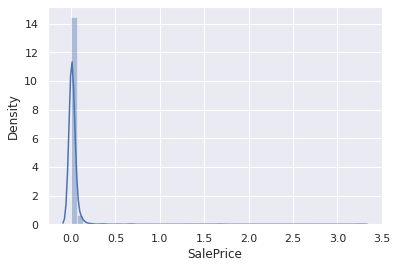

In [14]:
error = (y_train - model.predict(x_train)) ** 2
sns.distplot(error)

Выбросим из обучающей выборки объекты, которые дают такое большое отклонение

In [15]:
mask = (error < np.quantile(error, 0.95))

Попробуем ещё раз создать модель. Только уже с учётом найденного гиперпараметра и улучшенной тренировочной выборки

In [16]:
model = pipeline.fit(x_train[mask], y_train[mask])



y_pred = model.predict(x_test)
y_base = np.ones(y_pred.shape)
y_base = y_base * baseline
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test RMSE = %.4f" % mean_squared_error(y_base, y_pred, squared=False))

Test RMSE = 0.1427
Test RMSE = 0.3518


Проверим полученную модель на тестовых данных. Только перед этим, как и в случае начальных данных, выборку надо подготовить

In [17]:
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

id = test["Id"]
test = test.drop(columns=["Id"])

test.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [18]:
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
912,30,RM,51.000000,6120,Pave,Empty,Reg,Lvl,AllPub,Inside,...,120,0,Empty,MnPrv,Shed,620,7,2006,WD,Abnorml
373,20,RL,79.000000,10634,Pave,Empty,Reg,Lvl,AllPub,Inside,...,0,0,Empty,GdWo,Empty,0,11,2009,WD,Normal
20,60,RL,101.000000,14215,Pave,Empty,IR1,Lvl,AllPub,Corner,...,0,0,Empty,Empty,Empty,0,11,2006,New,Partial
800,60,RL,79.000000,12798,Pave,Empty,IR1,HLS,AllPub,Inside,...,0,0,Empty,Empty,Shed,400,5,2008,WD,Normal
152,60,RL,70.207101,14803,Pave,Empty,IR1,Lvl,AllPub,CulDSac,...,0,0,Empty,GdWo,Empty,0,6,2006,WD,Normal


In [19]:
numeric_data = test.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

test = test.fillna(numeric_data_mean)

categorical = list(test.dtypes[test.dtypes == 'object'].index)
test[categorical] = test[categorical].fillna('Empty')

In [20]:
y_pred = model.predict(test)


In [21]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Empty,Reg,Lvl,AllPub,Inside,...,120,0,Empty,MnPrv,Empty,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,Empty,IR1,Lvl,AllPub,Corner,...,0,0,Empty,Empty,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,Empty,IR1,Lvl,AllPub,Inside,...,0,0,Empty,MnPrv,Empty,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,Empty,IR1,Lvl,AllPub,Inside,...,0,0,Empty,Empty,Empty,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,Empty,IR1,HLS,AllPub,Inside,...,144,0,Empty,Empty,Empty,0,1,2010,WD,Normal


In [22]:
len(test.columns)

79

In [23]:
len(x_test.columns)

79

In [24]:
result = pd.DataFrame.from_dict({'Id' : id.values, 'SalePrice' : y_pred})
print(result)
result.to_csv('Result.csv', index = False)

        Id  SalePrice
0     1461  11.732052
1     1462  11.966620
2     1463  12.080343
3     1464  12.170571
4     1465  12.155216
...    ...        ...
1454  2915  11.506504
1455  2916  11.537381
1456  2917  12.074154
1457  2918  11.698147
1458  2919  12.363466

[1459 rows x 2 columns]
